<a href="https://colab.research.google.com/github/greenlytics/greenlytics_norrsken_hack/blob/master/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
from matplotlib import pyplot
from random import random
from random import randint
from numpy import array
from numpy import zeros
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import LSTM, GRU
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import TimeDistributed

In [0]:
# generate the next frame in the sequence
def next_frame(last_step, last_frame, column):
	# define the scope of the next step
	lower = max(0, last_step-1)
	upper = min(last_frame.shape[0]-1, last_step+1)
	# choose the row index for the next step
	step = randint(lower, upper)
	# copy the prior frame
	frame = last_frame.copy()
	# add the new step
	frame[step, column] = 1
	return frame, step

In [0]:
# generate a sequence of frames of a dot moving across an image
def build_frames(size):
	frames = list()
	# create the first frame
	frame = zeros((size,size))
	step = randint(0, size-1)
	# decide if we are heading left or right
	right = 1 if random() < 0.5 else 0
	col = 0 if right else size-1
	frame[step, col] = 1
	frames.append(frame)
	# create all remaining frames
	for i in range(1, size):
		col = i if right else size-1-i
		frame, step = next_frame(step, frame, col)
		frames.append(frame)
	return frames, right

In [0]:
# generate multiple sequences of frames and reshape for network input
def generate_examples(size, n_patterns):
  X, y = list(), list()
  for _ in range(n_patterns):
    frames, right = build_frames(size)
    X.append(frames[:int(size/2)])
    y.append(frames[int(size/2)])

  X = array(X)
  y = array(y)
  return X, y

In [0]:
X, y = generate_examples(10, 19)

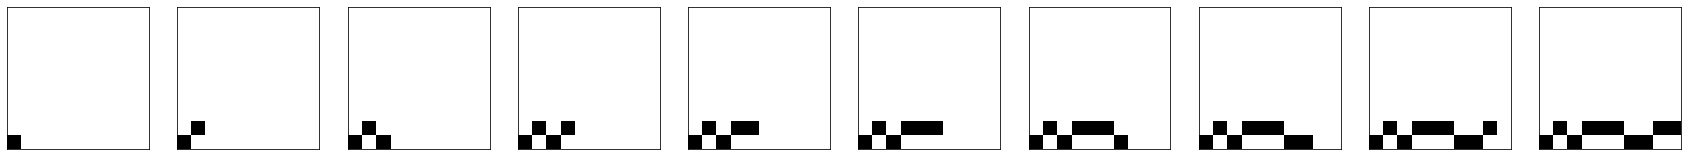

In [100]:
# generate sequence of frames
size = 10
frames, right = build_frames(size)
# plot all frames
pyplot.figure(figsize=(30,10))
for i in range(size):
	# create a gray scale subplot for each frame
	pyplot.subplot(1, size, i+1)
	pyplot.imshow(frames[i], cmap='Greys')
	# turn of the scale to make it clearer
	ax = pyplot.gca()
	ax.get_xaxis().set_visible(False)
	ax.get_yaxis().set_visible(False)
# show the plot
pyplot.show()

In [0]:
def build_model():
    latent_dim = 30
    
    X_decode = Input(shape=(None, n_bins))
    h_decode_input1 = Input(shape=(latent_dim,))
    c_decode_input1 = Input(shape=(latent_dim,))    
    h_decode_input2 = Input(shape=(latent_dim,))
    c_decode_input2 = Input(shape=(latent_dim,))    
    
    # Encoder
    h_out, h_encode_output1, c_encode_output1 = LSTM(latent_dim, return_sequences=True, return_state=True)(X_encode)
    _, h_encode_output2, c_encode_output2 = LSTM(latent_dim, return_state=True)(h_out)
    model_encoder = Model(X_encode, [h_encode_output1, c_encode_output1, h_encode_output2, c_encode_output2])

    # Decoder
    decoder_lstm1 = LSTM(latent_dim, return_sequences=True, return_state=True)
    decoder_lstm2 = LSTM(latent_dim, return_sequences=True, return_state=True)
    decoder_dense = Dense(units=n_bins, activation='softmax')
    h_out, h_decode_output1, c_decode_output1 = decoder_lstm1(X_decode, initial_state=[h_decode_input1, c_decode_input1])
    h_out, h_decode_output2, c_decode_output2 = decoder_lstm2(h_out, initial_state=[h_decode_input2, c_decode_input2])
    y_cat = decoder_dense(h_out)
    model_decoder = Model([X_decode, h_decode_input1, c_decode_input1, h_decode_input2, c_decode_input2], [y_cat, h_decode_output1, c_decode_output1, h_decode_output2, c_decode_output2])

    # Seq2seq
    h_out, _, _ = decoder_lstm1(X_decode, initial_state=[h_encode_output1, c_encode_output1])
    h_out, _, _ = decoder_lstm2(h_out, initial_state=[h_encode_output2, c_encode_output2])
    y_cat = decoder_dense(h_out)
    model_seq2seq = Model([X_encode, X_decode], y_cat)
    
    return model_seq2seq, model_encoder, model_decoder

In [107]:
# define the model
latent_dim = 50
X_encode = Input(shape=(None, int(size/2), size, size))
X_decode = Input(shape=(None, 1))
c_decode_input = Input(shape=(None, latent_dim,3))    

h_out = TimeDistributed(Conv2D(2, (2,2), activation='relu'))(X_encode)
h_out = TimeDistributed(Flatten())(h_out)
h_out, c_encode_output = GRU(latent_dim, return_sequences=False, return_state=True)(h_out)
model_encoder = Model(X_encode, [h_out, c_encode_output])

decoder_gru = GRU(latent_dim, return_sequences=True, return_state=True)
decoder_dense = Dense(units=1, activation='linear')
h_out, c_decode_output = decoder_gru(h_out, initial_state=c_decode_input)
y_cat = decoder_dense(h_out)
model_decoder = Model([X_decode, c_decode_input], [y_cat, c_decode_output])

# Seq2seq
h_out, _, _ = decoder_gru(X_decode, initial_state=[c_encode_output])
y_cat = decoder_dense(h_out)
model_seq2seq = Model(X_encode, y_cat)

model_seq2seq.summary()

ValueError: ignored